# Data Analyst & Integrator (Data Science) Take-Home Assignment (#5)
## Time Series Analysis

In this notebook we will train a model on the time series data and
see how it performs on 2019

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from itertools import groupby
from operator import itemgetter
import seaborn as sns
import csv
import sys
import re
%matplotlib inline

In [2]:
def read_tickets(path, encode='utf-8'):
    pd.options.mode.chained_assignment = None  # default='warn'

    # bad_lines catches errors in formatting
    headers = ["tag_number_masked", "date_of_infraction", "infraction_code", 
               "infraction_description", "set_fine_amount", "time_of_infraction", 
               "location1","location2","location3", "location4", "province", "bad_lines"]

    df = pd.read_csv(path, 
                     encoding=encode,  # not sure why this encoding was used for 08/10 and not other years
                     quotechar='"', 
                     names=headers,
                     low_memory=False)
                     #skiprows=1)

    # there were some error lines condensed into the location2
    bad_lines_df = df[df.bad_lines.notnull()]
    
    corrupt_line_index = bad_lines_df.index[0]
    
    bad_lines_list = bad_lines_df.to_csv(header=None, index=False).strip('\n').split('\r\n')
    bad_lines_df_2 = pd.DataFrame(bad_lines_list)[0].str.split(pat=",", expand=True) 
    
    try:
        bad_lines_df_2.columns = headers
        
        # fixing the last line
        bad_lines_df_2.tail(1)['location2'] = bad_lines_df.tail(1)['location3']
        bad_lines_df_2.tail(1)['location3'] = ''
        bad_lines_df_2.tail(1)['province'] = bad_lines_df.tail(1)['bad_lines']
        # drop last col
        bad_lines_df_2.drop(['bad_lines'], axis=1, inplace=True)
    except ValueError:
        bad_lines_df_2.columns = headers[:-1]
    

    # drop last col
    #bad_lines_df_2.drop(['bad_lines'], axis=1, inplace=True)
    df.drop(['bad_lines'], axis=1, inplace=True)
    df.drop([0, corrupt_line_index], inplace=True)
  
    # stack the two data frames
    df_cleaned = pd.concat([df, bad_lines_df_2]).reset_index(drop=True)
    df_cleaned = df_cleaned.astype({'date_of_infraction': 'int32', 'infraction_code':'int32', 'set_fine_amount':'int32'})

    del df
    del bad_lines_df_2
    return df_cleaned

In [3]:
tickets_2008 = read_tickets('../input/parking-tickets-data/parking-tickets-2008 (1)/Parking_Tags_data_2008.csv', 'UTF-16 LE')

In [4]:
tickets_2009 = read_tickets('../input/parking-tickets-data/parking-tickets-2009/Parking_Tags_data_2009.csv', 'utf-8')

In [5]:
tickets_2010 = read_tickets('../input/parking-tickets-data/parking-tickets-2010/Parking_Tags_data_2010.csv', 'UTF-16 LE')

In [6]:
# Get a list of csv files
csvs = []

for path, subdirs, files in os.walk("../input/parking-tickets-data"):
    for name in files:
        if name.lower().endswith('.csv'):
            csvs.append(os.path.join(path, name))

paths = [list(i) for j, i in groupby(csvs,
                  lambda a: a.split('_')[0])]


paths = sorted(paths, key=itemgetter(0))

years = {2008:tickets_2008, 2009: tickets_2009, 2010: tickets_2010}  # dictionary to contain the datafames with keys as the year

for i, path in enumerate(paths[3:]):
    key = i+2011
    value = pd.concat((pd.read_csv(f, quotechar='"') for f in path))
    years[key] = value

In [9]:
def remove_punctuation(text, disclude=""):
    from string import punctuation
    
    my_punctuation = punctuation.replace(disclude, "")
    
    # removes the following !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~
    no_punct = "".join([c for c in text if c not in my_punctuation])
    
    # no_punct = re.sub('[0-9]+', '', no_punct)
    
    # remove duplicated spaces and leading / trailing spaces
    no_punct = " ".join(no_punct.split())
    return no_punct

def shorten_rd(address):
    '''Completes the road type. I.e. Rd becomes Road, st becomes Street as per Google etc.'''
    address = address.title()
    address = re.sub(r" Street(?=$| [NE(So|S$)(We|W$)])", ' St', address)
    address = re.sub(r" Road(?=$| [NE(So|S$)(We|W$)])", ' Rd', address)
    address = re.sub(r"(?<!The) Avenue(?=$| [NE(So|S$)(We|W$)])", ' Ave', address)
    address = re.sub(r" Close(?=$| [NE(So|S$)(We|W$)])", ' Cl', address)
    address = re.sub(r" Court(?=$| [NE(So|S$)(We|W$)])", ' Ct', address)
    address = re.sub(r"(?<!The) Crescent(?=$| [NE(So|S$)(We|W$)])", ' Cres', address)
    address = re.sub(r" Boulevarde?(?=$| [NE(So|S$)(We|W$)])", ' Blvd', address)
    address = re.sub(r" Drive(?=$| [NE(So|S$)(We|W$)])", ' Dr', address)
    address = re.sub(r" Lane(?=$| [NE(So|S$)(We|W$)])", ' Ln', address)
    address = re.sub(r" Place(?=$| [NE(So|S$)(We|W$)])", ' Pl', address)
    address = re.sub(r" Square(?=$| [NE(So|S$)(We|W$)])", ' Sq', address)
    address = re.sub(r"(?<!The) Parade(?=$| [NE(So|S$)(We|W$)])", ' Pde', address)
    address = re.sub(r" Circuit(?=$| [NE(So|S$)(We|W$)])", ' Cct', address)
    return address

# this function keeps track of the number of unique columns before and after the cleaning is run
def cleaning_df_addresses(df, col_name):
    before = df[col_name].nunique()
    
    # clean the addresses, remove punctuation
    df[col_name] = df[col_name].apply(lambda x: remove_punctuation(str(x)))
    
    # lengthen addresses
    df[col_name] = df[col_name].apply(lambda x: shorten_rd(str(x).upper()))
    
    after = df[col_name].nunique()
    
    return before - after

In [10]:
# we want to make sure that the location2 is cleaned before encoding it
for year in range(2008,2020):
    cleaning_df_addresses(years[year], 'location2')

In [11]:
# convert the first problematic years to numeric
for i in range(2008,2011):
    years[i]['time_of_infraction'] = pd.to_numeric(years[i]['time_of_infraction'],errors='coerce')
    years[i][['date_of_infraction', 'set_fine_amount']] = years[i][['date_of_infraction', 'set_fine_amount']].astype(float)

In [12]:
# add in the date time values
for year in range(2008,2021):

    # add a datetime column, convert integer to datetime
    years[year]['date_of_infraction'] = pd.to_datetime(years[year].date_of_infraction.astype(str), format='%Y%m%d')
    years[year]['date_time_infraction'] = pd.to_datetime(years[year].date_of_infraction) + \
                                          pd.to_timedelta(years[year].time_of_infraction // 100, unit='H') + \
                                          pd.to_timedelta(years[year].time_of_infraction % 100, unit='T')
    
    # sort and reset the index 
    years[year] = years[year].sort_values(by='date_time_infraction',ascending=True).reset_index(drop=True)
    # we notice that there are some times missing, squish them together
    years[year]['date_time_infraction'].fillna(years[year]['date_of_infraction'], inplace=True)
    # drop time_of_infraction
    years[year].drop('time_of_infraction', inplace=True, axis=1)

# Time Series Analysis

In [13]:
from sklearn.preprocessing import LabelEncoder

# encode some of the values
for year in range(2008,2021):
    years[year][['tag_number_masked', 'infraction_description', 'location2']] = \
    years[year][['tag_number_masked', 'infraction_description', 'location2']].apply(LabelEncoder().fit_transform)

In [14]:
# resample by day
for year in range(2008,2020):
    years[year] = years[year].resample('D', on='date_of_infraction').agg({'tag_number_masked':'size',
                                                                          'set_fine_amount':'sum',
                                                                          'infraction_description':'size',
                                                                          'location2':'size'})

In [15]:
years[2008].head()

,tag_number_masked,set_fine_amount,infraction_description,location2
date_of_infraction,,,,
2008-01-01,644,29740.0,644,644
2008-01-02,6723,234360.0,6723,6723
2008-01-03,7740,266285.0,7740,7740
2008-01-04,8470,288820.0,8470,8470
2008-01-05,8080,265735.0,8080,8080


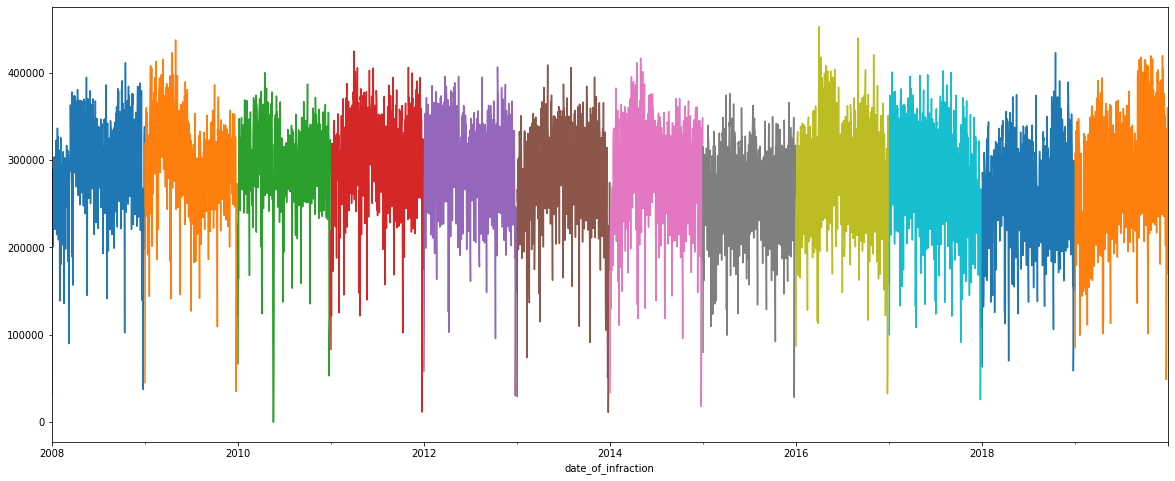

In [18]:
for year in range(2008,2020):
    years[year]['set_fine_amount'].plot(kind='line', figsize=(20,8));

## Feature Engineering

Add in values for the previous day as well as the difference

In [19]:
for year in range(2008,2020):

    # creating new dataframe from fine column

    # inserting new column with yesterday's fine values
    years[year].loc[:,'Yesterday'] = years[year].loc[:,'set_fine_amount'].shift()

    # inserting another column with difference between yesterday and day before yesterday's fine values
    years[year].loc[:,'Yesterday_Diff'] = years[year].loc[:,'Yesterday'].diff()

    years[year].dropna(inplace=True)

In [20]:
years[2016].head()

,tag_number_masked,set_fine_amount,infraction_description,location2,Yesterday,Yesterday_Diff
date_of_infraction,,,,,,
2016-01-03,4914,192035,4914,4914,216775.0,129395.0
2016-01-04,6017,290145,6017,6017,192035.0,-24740.0
2016-01-05,6725,314015,6725,6725,290145.0,98110.0
2016-01-06,6936,320500,6936,6936,314015.0,23870.0
2016-01-07,7031,332355,7031,7031,320500.0,6485.0


In [78]:
train_df = pd.concat([years[year] for year in range(2008,2019)])

In [79]:
train_df

,tag_number_masked,set_fine_amount,infraction_description,location2,Yesterday,Yesterday_Diff
date_of_infraction,,,,,,
2008-01-03,7740,266285.0,7740,7740,234360.0,204620.0
2008-01-04,8470,288820.0,8470,8470,266285.0,31925.0
2008-01-05,8080,265735.0,8080,8080,288820.0,22535.0
2008-01-06,6058,200790.0,6058,6058,265735.0,-23085.0
2008-01-07,7662,265565.0,7662,7662,200790.0,-64945.0
...,...,...,...,...,...,...
2018-12-27,5502,299470.0,5502,5502,83500.0,24765.0
2018-12-28,5524,287975.0,5524,5524,299470.0,215970.0
2018-12-29,4000,187495.0,4000,4000,287975.0,-11495.0


In [80]:
X_train = train_df.drop(['set_fine_amount'], axis=1)
y_train = train_df[['set_fine_amount']].values.ravel()
    
X_test = years[2019].drop(['set_fine_amount'], axis=1)
y_test = years[2019][['set_fine_amount']].values.ravel()

In [81]:
from sklearn.model_selection import TimeSeriesSplit
import sklearn.metrics as metrics

# Regression metrics
def regression_results(y_true, y_pred):
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)    
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

### Spot Check and Cross Validation

Cross validation TimeSeriesSplit

* fold 1: uses 2008 as training 2009 as validation
* fold 2: 2008, 2009 train, 2010 validation
* ...

LR: 0.802575 (0.164675)
KNN: 0.401513 (0.088974)
RF: 0.823352 (0.128777)
SVR: -0.168839 (0.188690)


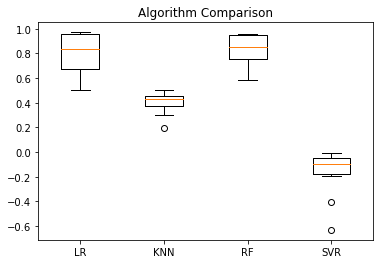

In [82]:
# Spot Check Algorithms
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


models = []
models.append(('LR', LinearRegression()))
# models.append(('NN', MLPRegressor(solver = 'lbfgs')))  # neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear

# Evaluate each model in turn
results = []
names = []
for name, model in models:
    
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=10)
    
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

Random forest is already a very promising start

## Grid Searching Hyperparameters

In [83]:
from sklearn.metrics import make_scorer
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score
rmse_score = make_scorer(rmse, greater_is_better = False)

In [84]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring=rmse_score)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [85]:
y_true = y_test
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.8954
mean_squared_log_error:  0.0111
r2:  0.8099
MAE:  24915.5774
MSE:  1055584033.9285
RMSE:  32489.7528


Lets take a look at the graph of the predicted and actual values

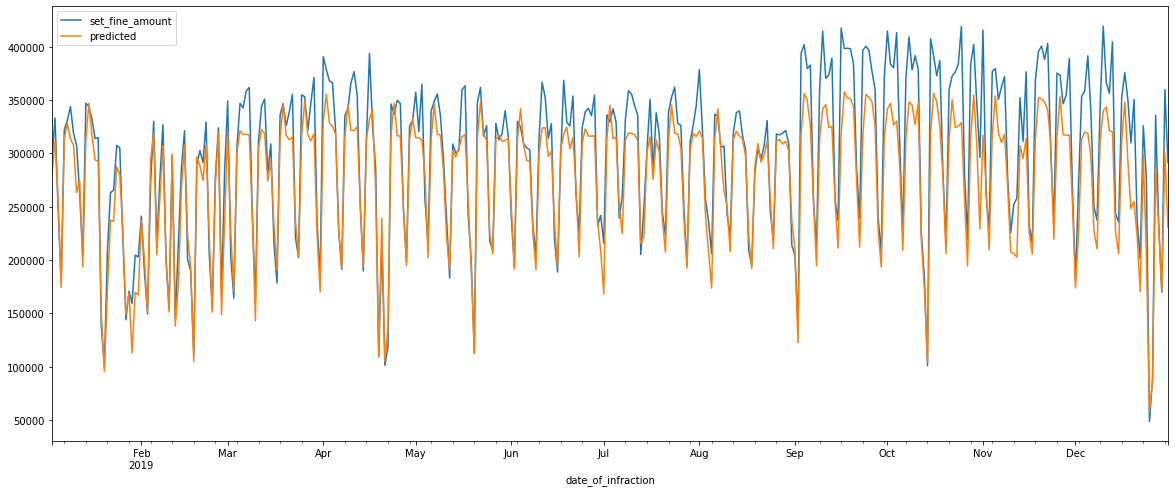

In [91]:
copy_2019 = years[2019]['set_fine_amount'].copy().to_frame()
copy_2019['predicted'] = y_pred
copy_2019.plot(figsize=(20,8));

Looks like we should be able to do better

## Feature Engineering Returns

Up until now, we have been using values at (t-1)th day to predict values on t date. Now, let us also use values from (t-2)days to predict revenue:

In [92]:
train_df_2 = pd.concat([years[year] for year in range(2008,2020)])

In [93]:
# inserting column with yesterday-1 values
train_df_2['Yesterday-1'] = train_df_2['Yesterday'].shift()

# inserting column with difference in yesterday-1 and yesterday-2 values.
train_df_2['Yesterday-1_Diff'] = train_df_2['Yesterday-1'].diff()

# dropping NAs
train_df_2 = train_df_2.dropna()

In [94]:
train_df_2

,tag_number_masked,set_fine_amount,infraction_description,location2,Yesterday,Yesterday_Diff,Yesterday-1,Yesterday-1_Diff
date_of_infraction,,,,,,,,
2008-01-05,8080,265735.0,8080,8080,288820.0,22535.0,266285.0,31925.0
2008-01-06,6058,200790.0,6058,6058,265735.0,-23085.0,288820.0,22535.0
2008-01-07,7662,265565.0,7662,7662,200790.0,-64945.0,265735.0,-23085.0
2008-01-08,7018,249375.0,7018,7018,265565.0,64775.0,200790.0,-64945.0
2008-01-09,6940,251060.0,6940,6940,249375.0,-16190.0,265565.0,64775.0
...,...,...,...,...,...,...,...,...
2019-12-27,6138,335880.0,6138,6138,88940.0,40270.0,48670.0,-227910.0
2019-12-28,4887,234350.0,4887,4887,335880.0,246940.0,88940.0,40270.0
2019-12-29,3691,170570.0,3691,3691,234350.0,-101530.0,335880.0,246940.0


### Reset the train / test

In [95]:
X_train_2 = train_df_2[:'2018'].drop(['set_fine_amount'], axis = 1)
y_train_2 = train_df_2.loc[:'2018', 'set_fine_amount']

X_test_2 = train_df_2['2019'].drop(['set_fine_amount'], axis = 1)
y_test_2 = train_df_2.loc['2019', 'set_fine_amount']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  after removing the cwd from sys.path.


In [96]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}

tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, 
                       param_grid=param_search, scoring = rmse_score)

gsearch.fit(X_train_2 , y_train_2)

best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

y_true = y_test_2
y_pred = best_model.predict(X_test_2)

regression_results(y_true, y_pred)

explained_variance:  0.8929
mean_squared_log_error:  0.0102
r2:  0.8301
MAE:  22891.4653
MSE:  943380034.437
RMSE:  30714.4923


## Variable Importance Plot

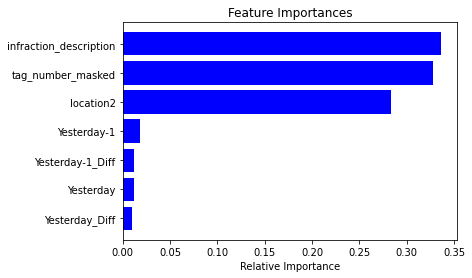

In [54]:
imp = best_model.feature_importances_
features = X_train_2.columns
indices = np.argsort(imp)

plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Let's try the normalized version

In [60]:
train_df_normalized=(train_df_2-train_df_2.min())/(train_df_2.max()-train_df_2.min())
train_df_normalized

,tag_number_masked,set_fine_amount,infraction_description,location2,Yesterday,Yesterday_Diff,Yesterday-1,Yesterday-1_Diff
date_of_infraction,,,,,,,,
2008-01-05,0.764355,0.587331,0.764355,0.764355,0.638354,0.510430,0.588547,0.526617
2008-01-06,0.573077,0.443789,0.573077,0.573077,0.587331,0.431784,0.638354,0.510430
2008-01-07,0.724813,0.586955,0.724813,0.724813,0.443789,0.359620,0.587331,0.431784
2008-01-08,0.663892,0.551172,0.663892,0.663892,0.586955,0.583249,0.443789,0.359620
2008-01-09,0.656513,0.554896,0.656513,0.656513,0.551172,0.443671,0.586955,0.583249
...,...,...,...,...,...,...,...,...
2019-12-27,0.580645,0.742366,0.580645,0.580645,0.196576,0.541004,0.107571,0.078680
2019-12-28,0.462303,0.517964,0.462303,0.462303,0.742366,0.897288,0.196576,0.541004
2019-12-29,0.349163,0.376996,0.349163,0.349163,0.517964,0.296550,0.742366,0.897288


In [61]:
X_train_3 = train_df_normalized[:'2018'].drop(['set_fine_amount'], axis = 1)
y_train_3 = train_df_normalized.loc[:'2018', 'set_fine_amount']

X_test_3 = train_df_normalized['2019'].drop(['set_fine_amount'], axis = 1)
y_test_3 = train_df_normalized.loc['2019', 'set_fine_amount']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  after removing the cwd from sys.path.


In [62]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}

tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, 
                       param_grid=param_search, scoring = rmse_score)

gsearch.fit(X_train_3 , y_train_3)

best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

y_true = y_test_3
y_pred = best_model.predict(X_test_3)

regression_results(y_true, y_pred)

explained_variance:  0.8918
mean_squared_log_error:  0.0017
r2:  0.8152
MAE:  0.0532
MSE:  0.005
RMSE:  0.0708
